<a href="https://github.com/maticvl/dataHacker/tree/master/pyTorch" target="_parent">This example extends the examples at this link</a>

### Computation graphs and Autograd in PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Simple example with gradients

Let's now see a simple example of how the derivative is calculated. We will create a scalar tensor `x` and set the `requires_grad` parameter to `True`.

In [6]:
# Create a tensor and set requires_grad=True to compute gradients
x = torch.tensor(3., requires_grad=True)
print("x", x)

x tensor(3., requires_grad=True)


We will calculate `y` the following way:\
$ y = 3x^2 + 4x + 2$

Now let's see what we get when we replace the `x` with our value `3`:  
$ y = 3(3)^2 + 4(3) + 2 $\
$ y = 3*9 + 12 + 2$\
$ y = 27 + 12 + 2 $\
$ y = 41 $
\
Now comes the part were we take the derivative of `y` with respect to the variable `x`.\
$\frac{dy}{dx} = 2*3x + 4 = 6x + 4$\
If we replace `x` with our value `3`, we get the following:
$6x + 4 = 6(3) + 4 = 18 + 4 = 22$\
So the gradient is equal to $22$\
Let's see how we can do this in code.

In [17]:
y = 3*x**2 + 4*x + 2
print("y = 3x^2 + 4x + 2 = ", y.item())

y = 3x^2 + 4x + 2 =  41.0


### Call `y.backward()` to calculate the derivative for that function.

In [18]:
# Compute the derivative of `y` with respect to `x`
y.backward()
print("derivative of `y` with respect to `x` =", x.grad)

derivative of `y` with respect to `x` = tensor(66.)


## Is there a way to turn off the gradient calculation ?

The answer is yes, you can turn the gradient calculation anytime.

In [19]:
x = torch.tensor(3., requires_grad=True)
print(x)

tensor(3., requires_grad=True)


In [20]:
x = x.requires_grad_(False)
print(x)

tensor(3.)


In [21]:
x = x.detach()
print(x)

tensor(3.)


# Gradient accumulation

The auto gradient calculation does not reset the gradients automatically, therefore we have to reset them after each optimization. If we forget this step they could end up just accumulating.\
This sounds complex, but it is not, it's easy. To reset the gradients for a particular tensor, you can simply pass `x.grad.zero_()` and it will reset the gradient. 

In [25]:
x = torch.tensor(3., requires_grad=True)

for epoch in range(3):
  y = 3*x**2 + 4*x + 2
  y.backward()

  print(x.grad)
  x.grad.zero_()

tensor(22.)
tensor(22.)
tensor(22.)


### Differentiation in Autograd
Let’s take a look at how autograd collects gradients. We create two tensors `a` and `b` with requires_grad=True. This signals to autograd that every operation on them should be tracked.

In [38]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor Q from a and b.
Q = 3a^3 - b^2

In [43]:
Q = 3*a**3 - b**2
print("Q = ", Q)

Q =  tensor([-12.,  65.], grad_fn=<SubBackward0>)


Let’s assume a and b to be parameters of an NN, and Q to be the error. In NN training, we want gradients of the error w.r.t. parameters, i.e.
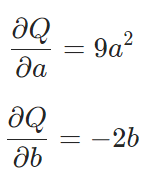

When we call .backward() on Q, autograd calculates these gradients and stores them in the respective tensors’ .grad attribute.

We need to explicitly pass a gradient argument in Q.backward() because it is a vector. gradient is a tensor of the same shape as Q, and it represents the gradient of Q w.r.t. itself, i.e.

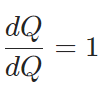

Equivalently, we can also aggregate Q into a scalar and call backward implicitly, like Q.sum().backward().


In [44]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

# check if collected gradients are correct
print("Derivative of Q w.r.t a = 9*a**2 = ", a.grad)
print("Derivative of Q w.r.t a = -2*b =", b.grad)

Derivative of Q w.r.t a = 9*a**2 =  tensor([ 72., 162.])
Derivative of Q w.r.t a = -2*b = tensor([-24., -16.])


## Optimizing parameters with autograd 

Create `x` tensor and compute `y` and `z` as follows:\
$y = 2x^2 + 3$\
$z = y^2$


In [32]:
x = torch.tensor([1.,2.,3.], requires_grad=True)
y = x * 2 + 3
z = y ** 2
print("z = ", z)

z =  tensor([25., 49., 81.], grad_fn=<PowBackward0>)


In [33]:
out = z.mean()
print("mean", out)
out.backward()
print("derivative", x.grad)

mean tensor(51.6667, grad_fn=<MeanBackward0>)
derivative tensor([ 6.6667,  9.3333, 12.0000])


In [36]:
x = torch.tensor([1.,2.,3.], requires_grad=True)
y = x * 2 + 3
z = y ** 2
print("z = ", z)

v = torch.tensor([1.,1.,1.])
z.backward(v)
print(x.grad)
print(x.grad/len(x))

z =  tensor([25., 49., 81.], grad_fn=<PowBackward0>)
tensor([20., 28., 36.])
tensor([ 6.6667,  9.3333, 12.0000])


Create a list for `w` and `b` in which we will save those values.

In [ ]:
x = torch.tensor([1.,2.,3.,4.,5])
y = x * 2 

In [ ]:
w_ = torch.tensor(5., requires_grad=True)
b_ = torch.tensor(1., requires_grad=True)

In [ ]:
for i_value in range(len(x)):
  w = torch.tensor(5., requires_grad=True)
  b = torch.tensor(1., requires_grad=True)

  y_hat = w * x[i_value] + b
  
  error = y_hat - y[i_value]
  loss = error ** 2 

  loss.backward()

  alpha = 0.01
  
  with torch.no_grad():
    w_.data -= alpha * (w.grad/len(x))
    b_.data -= alpha * (b.grad/len(x))

We will iterate and calculate the gradients for each value from the tensor `x_torch`. If we want to calculate the gradient for each number instead of the whole batch or list of numbers, we need to set the `w` and `b` parameters to the same number after calculation. After this step we do the forward pass for that number, and then we calculate the loss for that number and do the backpropagation. Update the `w` and `b` parameters and save them in the list we initialized earlier.

To get the final gradient we need to sum all of the gradients for all the numbers and divide them with the total number of values.

In [ ]:
print(w_)
print(b_)

In [ ]:
w_ = torch.tensor(5., requires_grad=True)
b_ = torch.tensor(1., requires_grad=True)

In [ ]:
y_hat = w * x + b
error = y_hat - y
loss = error ** 2

In [ ]:
loss=loss.mean()
loss.backward()

In [ ]:
w.data -= alpha * w.grad
b.data -= alpha * b.grad

Let's now see how we can do the same thing but just with the whole set of numbers.

In [ ]:
print(w)
print(b)